# Modeling Stock Market Sentiment with LSTM 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
# importing libraries

import os
import re
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import  matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import train_test_split
from collections import Counter

In [4]:
# Display

pd.set_option('max_colwidth', 800)
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [5]:
# current directory
os.getcwd()

'/home/siddharth/workspace-python/LSTM_stock_market_sentiment'

## Processing Data


Data used here is from **StockTwits.com** which is a social media network for traders and investors to share their views about the stock market. When a user posts a message, they tag the relevant stock ticker [$SPY in our case which is for S&P 500 index fund] and have option to tag the message with their sentiment - "bullish" or "bearish"

#### Read and view data

In [6]:
# read data from csv file
data = pd.read_csv('StockTwits_SPY_Sentiment_2017.gz',encoding='utf-8',index_col=0)

In [7]:
data.head()

,message,sentiment
0,$SPY crazy day so far!,bearish
1,$SPY Will make a new ATH this week. Watch it!,bullish
2,$SPY $DJIA white elephant in room is $AAPL. Up 14% since election. Strong headwinds w/Trump trade & Strong dollar. How many 7's do you see?,bearish
3,$SPY blocks above. We break above them We should push to double top,bullish
4,"$SPY Nothing happening in the market today, guess I'll go to the store and spend some $.",bearish


In [8]:
# Defining text messages and their labels

messages = data.message.values
labels = data.sentiment.values

#### Preprocess messages

Preprocessing the raw text data to normalize for the context. Normalizing for known unique 'entities' that carry similar contextual meaning. 

Therefore replacing the references to 
* specific stock ticker ($SPY), 
* user names, 
* url links,
* numbers with special tokenidentifying the entity 

Converting text into lower case and removing punctuations.               

In [9]:
def preprocess_messages(text):
    
    
    # SAVING REGEX PATTERNS
    REGEX_PRICE_SIGN = re.compile(r'\$(?!\d*\.?\d+%)\d*\.?\d+|(?!\d*\.?\d+%)\d*\.?\d+\$')
    REGEX_PRICE_NOSIGN = re.compile(r'(?!\d*\.?\d+%)(?!\d*\.?\d+k)\d*\.?\d+')
    REGEX_TICKER = re.compile('\$[a-zA-Z]+')
    REGEX_USER = re.compile('\@\w+')
    REGEX_LINK = re.compile('https?:\/\/[^\s]+')
    REGEX_HTML_ENTITY = re.compile('\&\w+')
    REGEX_NON_ACSII = re.compile('[^\x00-\x7f]')
    
    #string.punctuation - '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    #string.punctuation.replace('<', '').replace('>', '')
    #--> '!"#$%&\'()*+,-./:;=?@[\\]^_`{|}~'
    #re.escape(string.punctuation.replace('<', ''))
    #--> '\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~'
    
    REGEX_PUNCTUATION = re.compile('[%s]' % re.escape(string.punctuation.replace('<', '').replace('>', '')))
    REGEX_NUMBER = re.compile(r'[-+]?[0-9]+')
    
    
    # CONVERTING TO LOWERCASE
    text = text.lower()
    
    # REPLACE ST "ENTITITES" WITH A UNIQUE TOKEN
    text = re.sub(REGEX_TICKER, ' <TICKER> ', text)
    text = re.sub(REGEX_USER, ' <USER> ', text)
    text = re.sub(REGEX_LINK, ' <LINK> ', text)
    text = re.sub(REGEX_PRICE_SIGN, ' <PRICE> ', text)
    text = re.sub(REGEX_PRICE_NOSIGN, ' <NUMBER> ', text)
    text = re.sub(REGEX_NUMBER, ' <NUMBER> ', text)
    # REMOVE EXTRANEOUS TEXT DATA
    text = re.sub(REGEX_HTML_ENTITY, "", text)
    text = re.sub(REGEX_NON_ACSII, "", text)
    text = re.sub(REGEX_PUNCTUATION, "", text)
    
    # Tokenizing and removing < and > that are not in special tokens
    words = " ".join(token.replace("<", "").replace(">", "")
                     if token not in ['<TICKER>', '<USER>', '<LINK>', '<PRICE>', '<NUMBER>']
                     else token
                     for token in text.split())

    return words

In [10]:
messages = np.array([preprocess_messages(msg) for msg in messages])

#### Generate Vocab to index mapping

Encoding words to numbers for the alogrithm to work with inputs by encoding each word to a unique index.

In [11]:
vocab = " ".join(messages).split()

In [12]:
len(vocab)

1267980

In [13]:
len(set(vocab))

31980

In [14]:
word_idx = {word:idx for idx,word in enumerate(set(vocab),1)}
idx_word = {idx:word for word,idx in word_idx.items()}    

#### Checking messages length

In [15]:
message_len = [len(msg) for msg in messages]

print('Minimum length : ',min(message_len))
print('Maximum length : ',max(message_len))
print('Mean length : ',np.mean(message_len))

Minimum length :  0
Maximum length :  244
Mean length :  78.21856920395598


In [16]:
min_idx = [i  for i in range(len(message_len)) if message_len[i]==0]
print("Indexes where message length is 0 :",min_idx)

Indexes where message length is 0 : [88808]


In [17]:
print('messages length: ',len(messages))
print('no of labels: ',len(labels))

messages length:  96967
no of labels:  96967


In [18]:
# dropping zero message length message

messages = np.delete(messages,min_idx)
labels = np.delete(labels,min_idx)

In [19]:
print('messages length after removing of zero length messages: ',len(messages))
print('no of labels after removing of zero length messages: ',len(labels))

messages length after removing of zero length messages:  96966
no of labels after removing of zero length messages:  96966


#### Encoding Messages and Labels to the indexes

In [20]:
def encode_messages(messages,word_idx):
    encoded_msg = [] 
    for msg in messages:
        encoded_msg.append([word_idx[word] for word in msg.split()])
    
    return np.array(encoded_msg)

In [21]:
encoded_msg = encode_messages(messages,word_idx)
encoded_msg

array([list([28060, 13626, 16509, 1784, 29307]),
       list([28060, 9363, 5777, 26383, 14293, 2002, 27939, 28203, 12199, 1361]),
       list([28060, 28060, 3477, 10217, 11212, 18299, 29762, 28060, 25700, 30823, 20765, 7259, 6181, 7702, 24129, 17792, 6181, 4463, 10083, 20212, 30823, 5906, 24630, 11964, 21793]),
       ..., list([28060, 6607, 6064, 10258, 3131, 26845, 29618]),
       list([28060, 30823, 9813, 30991, 5158, 29762, 23301, 1809, 4568, 4151]),
       list([28060, 5436, 29762, 26383, 16509, 12316, 30170, 4370, 9253, 11964, 31326, 26383, 30823, 25826, 31655, 25946, 11964, 9953, 28455, 999, 26474, 13645, 27939, 9071, 28060, 28060, 28060])],
      dtype=object)

In [22]:
data.sentiment.nunique()

2

In [23]:
data.sentiment.value_counts()

bullish    53704
bearish    43263
Name: sentiment, dtype: int64

In [24]:
def encode_labels(labels):
    return np.array([0 if label=='bullish' else 1 for label in labels ])

In [25]:
encoded_label = encode_labels(labels)
encoded_label

array([1, 0, 1, ..., 1, 0, 0])

#### Zero Padding the messages

In [26]:
#finding the maximum sentence

len_encoded_msg = [len(i) for i in encoded_msg]
seq_len1 = max(len_encoded_msg)
seq_len1

39

In [27]:
# seq_len = max(message_len)
# seq_len

In [28]:
print('Minimum length : ',min(len_encoded_msg))
print('Maximum length : ',max(len_encoded_msg))
print('Mean length : ',np.mean(len_encoded_msg))

Minimum length :  1
Maximum length :  39
Mean length :  13.076542293174928


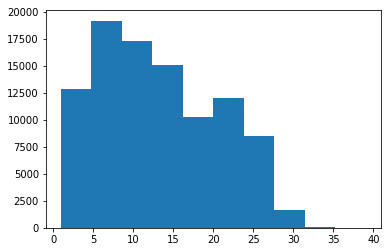

In [32]:
plt.hist(len_encoded_msg)
plt.show()

In [30]:
# padding the encoded_messages

padd_msg = np.zeros((len(encoded_msg),seq_len1))

for i,message in enumerate(encoded_msg):
    padd_msg[i,seq_len1-len(message):] = message

In [31]:
padd_msg.shape

(96966, 39)

#### Train,Test,Validation split

In [ ]:
# creating x and test split

x, x_test, y, y_test = train_test_split(padd_msg, encoded_label, test_size=0.1, random_state=42)

In [ ]:
# printing the shapes of the respective sets

print("Shape of x : ",x.shape)
print("Shape of y : ",y.shape)
print("Shape of x_test set : ",x_test.shape)
print("Shape of y_test set : ",y_test.shape)

In [ ]:
# creating train and validation split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)

In [ ]:
# printing the shapes of the respective sets

print("Shape of x_train : ",x_train.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of x_val set : ",x_val.shape)
print("Shape of y_val set : ",y_val.shape)

## Building and Training LSTM network

In [ ]:
def create_placeholders():
    'creating placeholders'
    
    with tf.variable_scope('Placeholders'):
        x_ph = tf.placeholder(tf.int32,[None,None],name ='x_ph')
        y_ph = tf.placeholder(tf.int32,None, name='y_ph')
        keep_prob_ph = tf.placeholder(tf.float32,name='keep_prob_ph')
    
    return x_ph,y_ph,keep_prob_ph

In [ ]:
def forward_propagation(x_ph,vocab_size,embed_size,lstm_neurons_li,keep_prob_ph,batch_size):
    
    # creating embedding layer
    with tf.variable_scope('Embedding_layer'):
        embedding = tf.Variable(tf.random_uniform((vocab_size,embed_size),minval=-1,maxval=1))
        embed_layer = tf.nn.embedding_lookup(embedding,x_ph)
    
    # creating LSTM layer
    with tf.variable_scope('LSTM_layer'):
        # creating lstm cells
        lstms = [tf.contrib.rnn.BasicLSTMCell(size,name='lstm_cell') for size in lstm_neurons_li]
        # adding dopout to the cells
        drops = [tf.contrib.rnn.DropoutWrapper(lstm,output_keep_prob = keep_prob_ph) for lstm in lstms]
        # stacking multiple LSTM layers
        cell = tf.contrib.rnn.MultiRNNCell(drops)
        
        
        # getting initial state of all zeros
        init_state = cell.zero_state(batch_size,tf.float32)
        #init_state = tf.identity(init_state, name="init_state")
        
        lstm_outputs,final_state = tf.nn.dynamic_rnn(cell,embed_layer,initial_state=init_state)
    
    # creating sigmoid fc layer
    with tf.variable_scope('FC_layer'):
        a_output = tf.contrib.layers.fully_connected(lstm_outputs[:,-1],1,activation_fn=tf.sigmoid)
    
    return init_state,a_output,cell,final_state

In [ ]:
def compute_cost(a_output,y_ph):
    
    with tf.variable_scope('Loss'):
        cost = tf.losses.mean_squared_error(y_ph,a_output)
    
    return cost

In [ ]:
# accuracy function

def acc_fn(a_output,y_ph):
    
    with tf.variable_scope('Accuracy'):
        correct_pred = tf.equal(tf.cast(tf.round(a_output),tf.int32),y_ph)
        accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))
    
    return accuracy

In [ ]:
def get_batches(x,y,batch_size = 100):
    
    n_batches = len(x)//batch_size
    
    # removing left out records
    x,y = x[:n_batches*batch_size],y[:n_batches*batch_size]
    
    for i in range(0,len(x),batch_size):
        yield x[i:i+batch_size],y[i:i+batch_size]

In [ ]:
# model_training

def model_train(x_train,y_train,x_val,y_val,vocab_size,
                embed_size=300,lstm_neurons_li=[128,64],
                keep_prob=0.5,learning_rate=1e-1,epochs=50,batch_size=256):
    
    # reset default graph
    tf.reset_default_graph()
    
    # create placeholder
    x_ph,y_ph,keep_prob_ph = create_placeholders()
    
    # forward propogation
    init_state,a_output,cell,final_state = forward_propagation(x_ph,vocab_size,
                                                                       embed_size,lstm_neurons_li,
                                                                       keep_prob_ph,batch_size)    
    
    # cost calculation
    cost = compute_cost(a_output,y_ph)
    
    # optimizers
    optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # accuracy definition
    accuracy = acc_fn(a_output,y_ph)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        n_batches = len(x_train)//batch_size
        
        for epoch in range(epochs):
            startime = datetime.now()
            state = sess.run(init_state)
            
            train_acc = []
            for step,(x,y) in enumerate(get_batches(x_train,y_train,batch_size),1):
                print('.',end=' ')
                feed = {x_ph:x,
                        y_ph:y,
                        keep_prob_ph:keep_prob,
                        init_state:state}
                
                loss_,state,_,batch_acc = sess.run([cost,final_state,optimizer,accuracy],feed_dict=feed)
                train_acc.append(batch_acc)
                
                # after the last batch is used for training i.e. after every epoch of training, evaluating result
                if (step)%n_batches == 0:
                    
                    val_acc = []
                    
                    val_state = sess.run(cell.zero_state(batch_size,tf.float32))
                    
                    for xx,yy in get_batches(x_val,y_val,batch_size):
                        feed_val = {x_ph:xx,
                                y_ph:yy,
                                keep_prob_ph:1,
                                init_state:val_state}
                        
                        val_batch_acc,val_state = sess.run([accuracy,final_state],feed_dict=feed_val)
                        val_acc.append(val_batch_acc)
                    
                    stoptime = datetime.now()
                    print()
                    print("Epoch: {}/{}...".format(epoch+1, epochs),
                          "Batch: {}/{}...".format(step, n_batches),
                          "Train Loss: {:.3f}...".format(loss_),
                          "Train Accruacy: {:.3f}...".format(np.mean(train_acc)),
                          "Val Accuracy: {:.3f}".format(np.mean(val_acc)),
                          "Epoch time: {}".format(str(stoptime-startime)))
            
            saver.save(sess,'./model_save1/sentiment.ckpt',global_step = epoch+1)
                    
            

In [ ]:
vocab_size = len(word_idx)+1

model_train(x_train,y_train,x_val,y_val,vocab_size,
                embed_size=300,lstm_neurons_li=[128,64],
                keep_prob=0.5,learning_rate=1e-1,epochs=50,batch_size=256)

In [ ]:
def model_test(model_dir,x_test,y_test,batch_size = 256):
    
    test_acc = []
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(model_dir+'.meta')
        saver.restore(sess,model_dir)
        
        graph = tf.get_default_graph()
                
        y_ph = graph.get_tensor_by_name('Placeholders/y_ph:0')
        x_ph = graph.get_tensor_by_name('Placeholders/x_ph:0')
        keep_prob_ph = graph.get_tensor_by_name('Placeholders/keep_prob_ph:0')
        accuracy = graph.get_tensor_by_name('Accuracy/Mean:0')
        
        for i,(x,y) in enumerate(get_batches(x_test,y_test,batch_size),1):
            feed_test = {x_ph:x,
                         y_ph:y,
                         keep_prob_ph:1}                         
            
            batch_acc = sess.run([accuracy],feed_dict=feed_test)
            test_acc.append(batch_acc)
        print("Test Accuracy : {:.3f}".format(np.mean(test_acc)))

In [ ]:
model_dir = 'model_save/sentiment.ckpt-1'
model_test(model_dir,x_test,y_test,batch_size = 256)